In [48]:
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from time import time
from typing import List
from fvcore.nn import FlopCountAnalysis
from src.models.lbcnn.lbc_unet import SkinnySmallUNetLBP, SmallUNetLBP
from src.models.unet.unet_model import SkinnySmallUNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, SkinnyDSCSmallUNetLBP
from src.models.dsc.dsc_unet import SkinnySmallUNetDSC, SmallUNetDSC

In [49]:
def load_json_metrics(file_path):
    with open(file_path, 'r') as fp:
        metrics = json.load(fp)
    return metrics

def plot_json(json_dict, name, ax):
    ax.plot(list(json_dict.keys()), list(json_dict.values()), label=name)
    
def get_mean_metric(metric_dict, from_epoch, to_epoch=None):
    df = pd.DataFrame.from_dict(metric_dict, orient='index')
    return df[from_epoch:to_epoch].mean().item()

def get_n_params(model, verbose=False):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print('Total Params: ', pytorch_total_params)

    params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            params += param.numel()
    if verbose:
        print('Trainable Params: ', params)
    return pytorch_total_params, params

def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def early_stopping(epoch_metric_list, tolerance):
    max_metric = epoch_metric_list[0]
    lower_count = 0
    stopping_epoch = 0
    for i, x in enumerate(epoch_metric_list):
        if lower_count >= tolerance:
            stopping_epoch = i - tolerance
            break
        if x < max_metric:
            lower_count += 1
        else:
            max_metric = x
            lower_count = 0
    if stopping_epoch:
        return stopping_epoch
    else:
        return i - lower_count + 1

def early_stopping_loss(epoch_metric_list, tolerance):
    min_metric = epoch_metric_list[0]
    higher_count = 0
    stopping_epoch = 0
    for i, x in enumerate(epoch_metric_list):
        if higher_count >= tolerance:
            stopping_epoch = i - tolerance
            break
        if x > min_metric:
            higher_count += 1
        else:
            min_metric = x
            higher_count = 0
    if stopping_epoch:
        return stopping_epoch
    else:
        return i - higher_count + 1

In [89]:
metric_of_interest = 'iou'

# UNet
unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/frosty_sponge_239_unet_ice-mean-{metric_of_interest}-epoch.json')

# LBC UNet
lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/worthy_wood_227_lbc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Deeplab MobileNet
deeplab_mobile_net = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/vivid_donkey_305_deeplab_mobilenet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Deeplab MobileNet
lraspp_mobile_net = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/clean_darkness_312_laraspp_mobilenet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# DSC UNet
dsc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/helpful_fire_308_unet_dsc_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# DSC LBC UNet
dsc_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/youthful_microwave_310_lbc_dsc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Skinny UNet
skinny_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_skinny/noble_forest_358_skinny_small_unet-mean-{metric_of_interest}-epoch.json')

# Skinny LBC UNet
skinny_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_skinny/trim_field_359_skinny_small_lbc_unet-mean-{metric_of_interest}-epoch.json')

# Skinny DSC UNet
skinny_dsc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_skinny/ancient_grass_357_skinny_small_dsc_unet-mean-{metric_of_interest}-epoch.json')

# Skinny DSC LBC UNet
skinny_dsc_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_skinny/clear_lake_355_skinny_small_dsc_lbc_unet-mean-{metric_of_interest}-epoch.json')


metric_dicts = {
    'skinny_unet': skinny_unet, 
    'unet': unet,
    'skinny_lbc_unet': skinny_lbc_unet, 
    'lbc_unet': lbc_unet,
    'skinny_dsc_unet': skinny_dsc_unet,
    'dsc_unet': dsc_unet,
    'skinny_dsc_lbc_unet': skinny_dsc_lbc_unet,
    'dsc_lbc_unet': dsc_lbc_unet,
    'lraspp_mobile_net': lraspp_mobile_net,
    'deeplab_mobile_net': deeplab_mobile_net,
}

In [97]:
stopping_epochs = 30
stopping_list_iou = []

for model in metric_dicts.keys():
    epoch_metrics = list(metric_dicts[model].values())
    stop = early_stopping(epoch_metrics, stopping_epochs)
    stopping_list_iou.append((model, stop, round(epoch_metrics[stop-1], 2)))

In [98]:
stopping_list_iou

[('skinny_unet', 39, 0.75),
 ('unet', 34, 0.72),
 ('skinny_lbc_unet', 27, 0.72),
 ('lbc_unet', 15, 0.71),
 ('skinny_dsc_unet', 27, 0.73),
 ('dsc_unet', 27, 0.71),
 ('skinny_dsc_lbc_unet', 49, 0.73),
 ('dsc_lbc_unet', 16, 0.69),
 ('lraspp_mobile_net', 20, 0.65),
 ('deeplab_mobile_net', 54, 0.65)]

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

ax.set_ylabel('IoU Score')
ax.set_xlabel('Epoch')
plot_json(deeplab_mobile_net, 'deeplab_mobile_net', ax)
plot_json(lraspp_mobile_net, 'lraspp_mobile_net', ax)
plt.legend();

In [61]:
stopping_epochs = 30
stopping_list_iou = []

0.7503377795219421


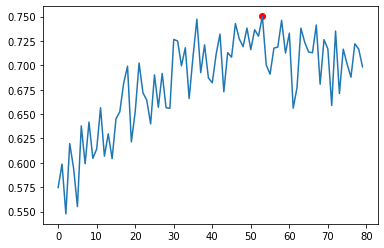

In [52]:
epoch_metrics = list(small_unet.values())
stop = early_stopping(epoch_metrics, stopping_epochs)
plt.plot(epoch_metrics)
plt.scatter(stop-1, epoch_metrics[stop-1], c='r')
stopping_list_iou.append((stop, epoch_metrics[stop-1]))
print(epoch_metrics[stop-1])

0.6806187629699707


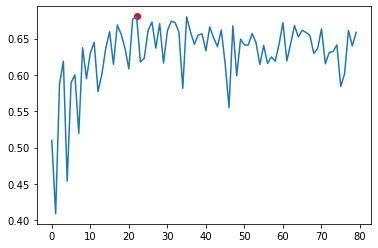

In [53]:
epoch_metrics = list(small_lbc_unet.values())
stop = early_stopping(epoch_metrics, stopping_epochs)
plt.plot(epoch_metrics)
plt.scatter(stop-1, epoch_metrics[stop-1], c='r')
stopping_list_iou.append((stop, epoch_metrics[stop-1]))
print(epoch_metrics[stop-1])

0.7378992438316345


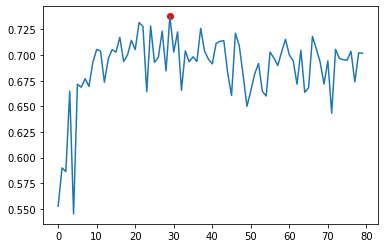

In [54]:
epoch_metrics = list(small_dsc_unet.values())
stop = early_stopping(epoch_metrics, stopping_epochs)
plt.plot(epoch_metrics)
plt.scatter(stop-1, epoch_metrics[stop-1], c='r')
stopping_list_iou.append((stop, epoch_metrics[stop-1]))
print(epoch_metrics[stop-1])

0.7378728985786438


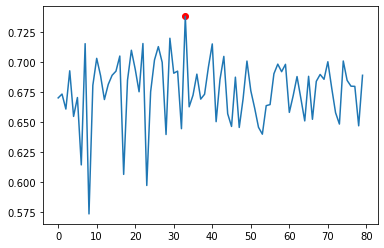

In [55]:
epoch_metrics = list(small_dsc_lbc_unet.values())
stop = early_stopping(epoch_metrics, stopping_epochs)
plt.plot(epoch_metrics)
plt.scatter(stop-1, epoch_metrics[stop-1], c='r')
stopping_list_iou.append((stop, epoch_metrics[stop-1]))
print(epoch_metrics[stop-1])

0.7473847270011902


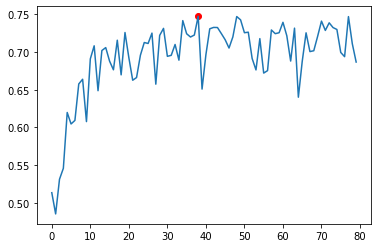

In [62]:
epoch_metrics = list(skinny_unet.values())
stop = early_stopping(epoch_metrics, stopping_epochs)
plt.plot(epoch_metrics)
plt.scatter(stop-1, epoch_metrics[stop-1], c='r')
stopping_list_iou.append((stop, epoch_metrics[stop-1]))
print(epoch_metrics[stop-1])

0.7182584404945374


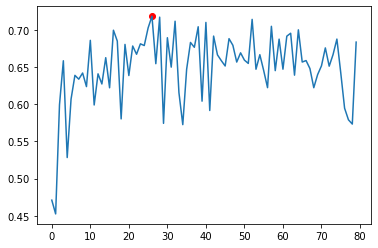

In [63]:
epoch_metrics = list(skinny_lbc_unet.values())
stop = early_stopping(epoch_metrics, stopping_epochs)
plt.plot(epoch_metrics)
plt.scatter(stop-1, epoch_metrics[stop-1], c='r')
stopping_list_iou.append((stop, epoch_metrics[stop-1]))
print(epoch_metrics[stop-1])

0.7267563939094543


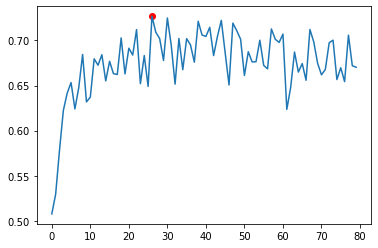

In [64]:
epoch_metrics = list(skinny_dsc_unet.values())
stop = early_stopping(epoch_metrics, stopping_epochs)
plt.plot(epoch_metrics)
plt.scatter(stop-1, epoch_metrics[stop-1], c='r')
stopping_list_iou.append((stop, epoch_metrics[stop-1]))
print(epoch_metrics[stop-1])

0.7318708896636963


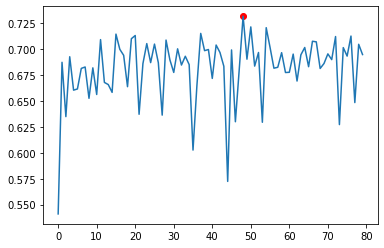

In [65]:
epoch_metrics = list(skinny_dsc_lbc_unet.values())
stop = early_stopping(epoch_metrics, stopping_epochs)
plt.plot(epoch_metrics)
plt.scatter(stop-1, epoch_metrics[stop-1], c='r')
stopping_list_iou.append((stop, epoch_metrics[stop-1]))
print(epoch_metrics[stop-1])

In [66]:
stopping_list_iou

[(39, 0.7473847270011902),
 (27, 0.7182584404945374),
 (27, 0.7267563939094543),
 (49, 0.7318708896636963)]

In [67]:
metric_of_interest = 'loss'

# Skinny UNet
skinny_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_skinny/noble_forest_358_skinny_small_unet-mean-{metric_of_interest}-epoch.json')

# Skinny LBC UNet
skinny_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_skinny/trim_field_359_skinny_small_lbc_unet-mean-{metric_of_interest}-epoch.json')

# Skinny DSC UNet
skinny_dsc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_skinny/ancient_grass_357_skinny_small_dsc_unet-mean-{metric_of_interest}-epoch.json')

# Skinny DSC LBC UNet
skinny_dsc_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_skinny/clear_lake_355_skinny_small_dsc_lbc_unet-mean-{metric_of_interest}-epoch.json')


metric_dicts = {
    'skinny_unet': skinny_unet, 
    'skinny_lbc_unet': skinny_lbc_unet, 
    'skinny_dsc_unet': skinny_dsc_unet,
    'skinny_dsc_lbc_unet': skinny_dsc_lbc_unet,
}

In [75]:
stopping_epochs = 10
stopping_list_loss = []

0.27921736240386963


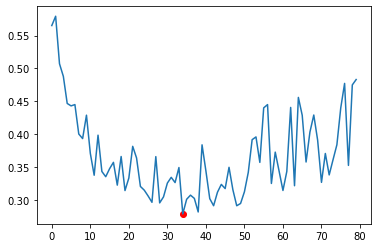

In [76]:
epoch_metrics = list(skinny_unet.values())
stop = early_stopping_loss(epoch_metrics, stopping_epochs)
plt.plot(epoch_metrics)
plt.scatter(stop-1, epoch_metrics[stop-1], c='r')
stopping_list_loss.append((stop, epoch_metrics[stop-1]))
print(epoch_metrics[stop-1])

0.27692466974258423


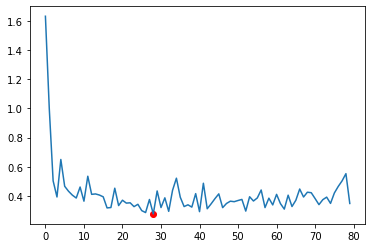

In [77]:
epoch_metrics = list(skinny_lbc_unet.values())
stop = early_stopping_loss(epoch_metrics, stopping_epochs)
plt.plot(epoch_metrics)
plt.scatter(stop-1, epoch_metrics[stop-1], c='r')
stopping_list_loss.append((stop, epoch_metrics[stop-1]))
print(epoch_metrics[stop-1])

0.3119736611843109


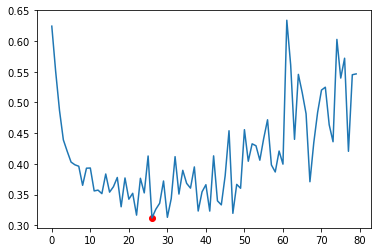

In [78]:
epoch_metrics = list(skinny_dsc_unet.values())
stop = early_stopping_loss(epoch_metrics, stopping_epochs)
plt.plot(epoch_metrics)
plt.scatter(stop-1, epoch_metrics[stop-1], c='r')
stopping_list_loss.append((stop, epoch_metrics[stop-1]))
print(epoch_metrics[stop-1])

0.2951734662055969


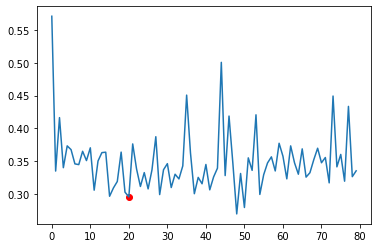

In [79]:
epoch_metrics = list(skinny_dsc_lbc_unet.values())
stop = early_stopping_loss(epoch_metrics, stopping_epochs)
plt.plot(epoch_metrics)
plt.scatter(stop-1, epoch_metrics[stop-1], c='r')
stopping_list_loss.append((stop, epoch_metrics[stop-1]))
print(epoch_metrics[stop-1])

In [80]:
stopping_list_iou

[(39, 0.7473847270011902),
 (27, 0.7182584404945374),
 (27, 0.7267563939094543),
 (49, 0.7318708896636963)]

In [81]:
stopping_list_loss

[(35, 0.27921736240386963),
 (29, 0.27692466974258423),
 (27, 0.3119736611843109),
 (21, 0.2951734662055969)]

In [86]:
list(skinny_dsc_lbc_unet.values())[21-1]

0.7132598757743835